# Multi-channel slow-wave detection

This notebook demonstrates how to use YASA to perform **multi-channel slow-waves detection** from a NumPy array (example 1) or a MNE Raw object (example 2). If you haven't done so already, check out the notebook on [single-channel slow-waves detection](05_sw_detection.ipynb).

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$. Note that the default unit in [MNE](https://martinos.org/mne/dev/generated/mne.io.Raw.html) is $V$. Therefore, if you use MNE, you must multiply your data by 1e6 (1 $V$ = 1,000,000 $\mu V$).

## Example 1: Using NumPy

To illustrate the multi-channel slow-waves detection, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, chan = f['data'], f['chan']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, chan)

(3, 2161058) ['Cz' 'Fz' 'Pz']


To apply the multi-channel detection, we use the [sw_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html#yasa.spindles_detect) function. Note that we pass the hypnogram and restrain the detection to N2 or N3 sleep.

In [2]:
sw = yasa.sw_detect(data, sf, ch_names=chan, hypno=hypno, include=(2, 3))

# Get the full detection dataframe
sw.summary().round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,529.52,529.77,530.00,530.23,530.52,1.00,-47.73,29.48,77.21,335.71,1.00,2,Cz,0
1,572.23,572.93,573.15,573.35,574.08,1.85,-73.97,65.18,139.15,632.49,0.54,2,Cz,0
2,591.76,591.99,592.20,592.35,592.56,0.80,-112.44,55.74,168.18,800.85,1.25,2,Cz,0
3,631.90,632.16,632.74,632.96,633.18,1.28,-45.32,43.93,89.25,153.88,0.78,2,Cz,0
4,644.24,644.60,644.78,644.96,645.14,0.90,-60.87,65.22,126.09,700.50,1.11,2,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,20502.96,20503.15,20503.35,20503.95,20504.42,1.46,-50.87,32.59,83.46,417.32,0.68,2,Pz,2
8365,20523.90,20524.15,20524.34,20524.57,20525.06,1.16,-79.55,86.82,166.38,875.67,0.86,2,Pz,2
8366,20525.58,20526.20,20526.47,20526.91,20527.37,1.79,-89.16,52.16,141.32,523.39,0.56,2,Pz,2
8367,20531.52,20531.76,20531.99,20532.56,20532.86,1.34,-42.89,66.84,109.72,477.06,0.75,2,Pz,2


In [3]:
# Get the average per channel and stage
sw.summary(grp_chan=True, grp_stage=True, aggfunc='mean')

Count    Density  Duration  ValNegPeak  ValPosPeak         PTP  \
Stage Channel                                                                   
2     Cz         620   3.924361  1.708419  -84.758436   58.113506  142.871942   
      Fz         575   3.639528  1.679791  -99.785366   56.973591  156.758957   
      Pz         516   3.266081  1.901957  -76.117292   58.046989  134.164281   
3     Cz        2255  25.192012  1.112106  -82.273446   65.193923  147.467369   
      Fz        2183  24.387655  1.107971  -79.893034   60.553331  140.446365   
      Pz        2220  24.801005  1.135482  -81.980608   64.978213  146.958820   

                    Slope  Frequency  
Stage Channel                         
2     Cz       624.925758   0.954548  
      Fz       684.936279   0.996568  
      Pz       545.678410   0.874453  
3     Cz       617.477507   0.973076  
      Fz       608.296145   0.976447  
      Pz       595.871965   0.958450

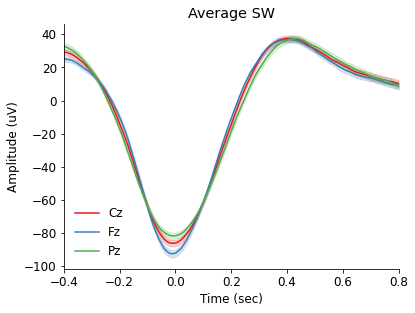

In [4]:
# Plot an average template of the detected slow-waves, centered around the negative peak
ax = sw.plot_average(center="NegPeak", time_before=0.4, 
                     time_after=0.8, palette="Set1")
ax.legend(frameon=False)
sns.despine()

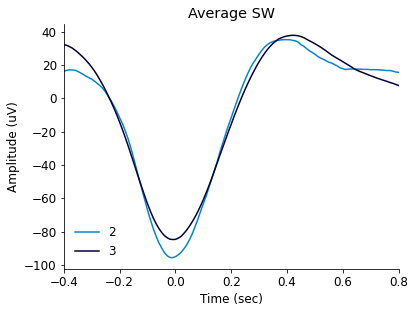

In [5]:
# Same but grouped by stage, using the `hue="Stage"` input parameter (default is "Channel")
# Note that we're also disabling the time-consuming bootstrapped confidence 
# intervals with `ci=None`.
ax = sw.plot_average(center="NegPeak", hue="Stage", time_before=0.4, 
                     time_after=0.8, ci=None,
                     palette=["xkcd:cerulean", "xkcd:midnight blue"])
ax.legend(frameon=False)
sns.despine()

**Grouped by both stage and channel**

While YASA does not directly support grouping by both channel and stage, it is possible with just a few lines of code.

In [6]:
# First, we need to get a long-format dataframe of peak-locked event.
df_sync = sw.get_sync_events(center="NegPeak", time_before=0.4, time_after=0.8)
df_sync

,Time,Event,Amplitude,Stage,Channel,IdxChannel
0,-0.40,0,9.956640,2,Cz,0
1,-0.39,0,11.871379,2,Cz,0
2,-0.38,0,7.850428,2,Cz,0
3,-0.37,0,6.414374,2,Cz,0
4,-0.36,0,8.616323,2,Cz,0
...,...,...,...,...,...,...
1012644,0.76,2735,22.494850,2,Pz,2
1012645,0.77,2735,11.397391,2,Pz,2
1012646,0.78,2735,5.798673,2,Pz,2
1012647,0.79,2735,0.299931,2,Pz,2


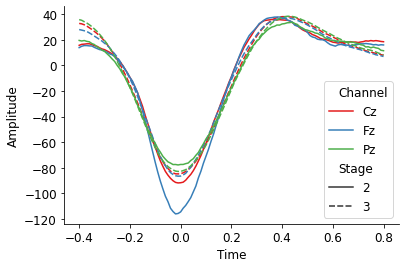

In [7]:
# Then we can use seaborn.lineplot to create the desired plot:
ax = sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue="Channel", 
                  style="Stage", palette="Set1", ci=None, dashes=True)

sns.despine()

*************

## Example 2: Using a Raw object from MNE-Python

This example demonstrates how to manipulate [MNE Raw object](https://mne-tools.github.io/stable/generated/mne.io.Raw.html#mne.io.Raw). The MNE package has several [functions](https://mne-tools.github.io/stable/python_reference.html#module-mne.io) to load the most standard EEG file formats (EDF, BrainVision, EEGLab, FieldTrip...).

For the sake of this example, we'll load a PSG file encoded in the native MNE format (*.fif) using the [mne.io.read_raw_fif](https://martinos.org/mne/stable/generated/mne.io.read_raw_fif.html) function.

In [8]:
# Load the raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)

In [9]:
# Let's have a look at the data
print('Chan =', raw.ch_names)
print('Sampling frequency =', raw.info['sfreq'])
print('Data shape =', raw._data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
Sampling frequency = 100.0
Data shape = (9, 294000)


In [10]:
# Keep only the channels of interests
raw_eeg = raw.copy().pick_types(eeg=True).drop_channels(['O1', 'O2'])
print('Chan =', raw_eeg.ch_names)

Chan = ['F3', 'F4', 'C3', 'C4']


In [11]:
# Multi-channel slow-waves detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names.
# We also use a less conservative amplitude threshold
sw = yasa.sw_detect(raw_eeg, amp_ptp=(50, 400))
print(sw.summary().shape[0], 'slow-waves detected.')
sw.summary().round(3)

422 slow-waves detected.


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,0.43,0.64,0.83,0.98,1.14,0.71,-58.425,35.605,94.030,494.895,1.408,F3,0
1,13.84,14.06,14.29,14.53,14.79,0.95,-40.706,39.630,80.336,349.288,1.053,F3,0
2,15.23,15.85,16.02,16.22,16.49,1.26,-95.548,116.929,212.478,1249.868,0.794,F3,0
3,38.04,38.23,38.38,38.51,38.62,0.58,-48.818,44.427,93.245,621.633,1.724,F3,0
4,38.62,38.81,38.96,39.14,39.34,0.72,-108.542,116.249,224.791,1498.608,1.389,F3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,2844.04,2844.21,2844.35,2844.54,2844.74,0.70,-47.042,63.035,110.077,786.264,1.429,C4,3
418,2844.74,2845.09,2845.33,2845.49,2846.14,1.40,-129.779,57.846,187.625,781.770,0.714,C4,3
419,2846.14,2846.32,2846.65,2846.91,2847.06,0.92,-82.205,23.864,106.069,321.421,1.087,C4,3
420,2898.91,2899.55,2899.78,2899.99,2900.57,1.66,-68.929,55.645,124.574,541.625,0.602,C4,3


In [12]:
sw.summary(grp_chan=True)

,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Channel,,,,,,,
C3,77,1.067922,-67.329890,45.141157,112.471047,504.474158,1.010236
C4,76,1.110263,-76.330042,53.537405,129.867446,604.780685,0.988322
F3,148,1.079054,-69.190826,48.691428,117.882255,544.335451,1.003892
F4,121,1.075207,-67.909778,43.902334,111.812112,485.998248,1.014117


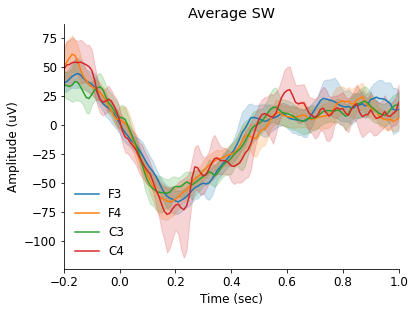

In [13]:
# Plot an average template of the detected slow-waves, centered around the start of the slow-wave
# Definitely noiser than our previous plot since there are fewer detected slow-waves
# in our second datset, because it's a 45 min nap and not a full-night recording!
ax = sw.plot_average(center="Start", time_before=0.2, time_after=1)
ax.legend(frameon=False)
sns.despine()

In [14]:
# Visual inspection of the detected slow-waves
%matplotlib widget
sw.plot_detection();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…